# Curve fitting test

In [1]:
#Pull in all the normal math functions and set up matplotlib as inline plotting (i.e. Mathematica like)
%pylab inline
#import the curve_fit function
from scipy.optimize import curve_fit
from peaks.gauss2d import Gauss2D
import scipy.optimize.minpack as mp
curve_fit = mp.curve_fit

set_cmap('gnuplot2')

Populating the interactive namespace from numpy and matplotlib


Below we define a simple exponential decay function of the form
$$y(x)=a e^{-b x}+c$$

In [2]:
#Here's a simple test function of an exponential decay
def func(x, *params):
    #this is the important part, if you want to pass an unspecified number of parameters
    #you need to unpack the parameters list in the function definition and then you need
    #to specify initial guesses when using curve_fit
    return params[0] * exp(-params[1] * x) + params[2]

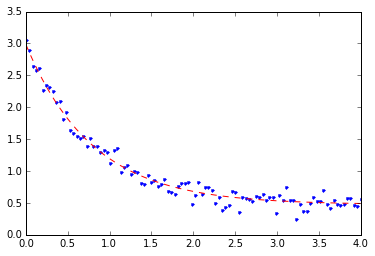

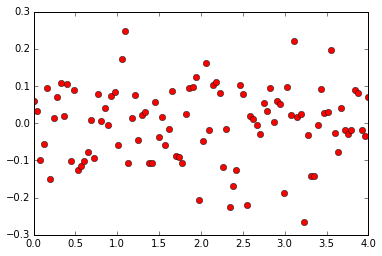

In [3]:
#Here we generate some fake data
xdata = linspace(0, 4, 100)
y = func(xdata, 2.5, 1.3, 0.5)

#add gaussian white noise
ydata = y + 0.1 * random.normal(size=len(xdata))

#perform the curve_fit, NOTE: you have to give guesses so that curve fit can determine
#the correct number of parameters for the function func
popt, pcov = curve_fit(func, xdata, ydata,p0=ones(3))

#generate a nice fit
x_fit=linspace(0,4,1024)
fit = func(x_fit,*popt) #you need to use the '*' operator to unpack the array specifically
plot(xdata,ydata,'.',x_fit,fit,'--r')
figure()
plot(xdata,ydata-func(xdata,*popt),'ro')

In [4]:
#Let's try writing a function that fits lorentzian peaks
def lor(x, *p):
    toReturn = zeros(len(x)) #initialize our returned array
    toReturn += p[0] #first parameter is the offset
    if (len(p)-1)%3 != 0:
        #Here's where we should raise an error
        pass
    
    for i in range(1,len(p),3):
        toReturn += p[i]/(((x-p[i+1])/p[i+2])**2+1)
        
    return toReturn

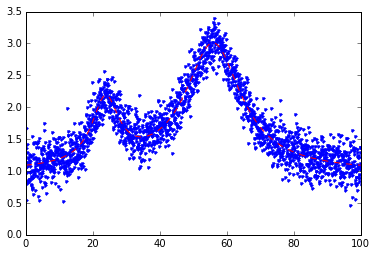

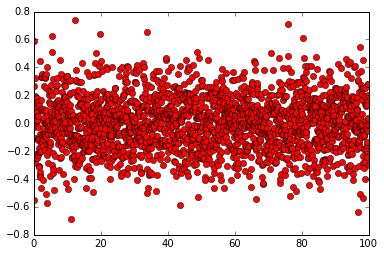

In [5]:
#Here we generate some fake data
xdata = linspace(0, 100, 2048)
p = [1,1,24,5,2,56,10]
y = lor(xdata, *p)

#add gaussian white noise
ydata = y + 0.2 * random.normal(size=len(xdata))

#perform the curve_fit, NOTE: you have to give guesses so that curve fit can determine
#the correct number of parameters for the function func
popt, pcov = curve_fit(lor, xdata, ydata,p0=p)

#generate a nice fit
fit = lor(xdata,*popt) #you need to use the '*' operator to unpack the array specifically
plot(xdata,ydata,'.',xdata,fit,'--r')
figure()
plot(xdata,ydata-lor(xdata,*popt),'ro')

#2D Fitting

Here I've taken the code from [here](http://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m).

There's a better definition of a skewed gaussian available [here](http://mathworld.wolfram.com/BivariateNormalDistribution.html).

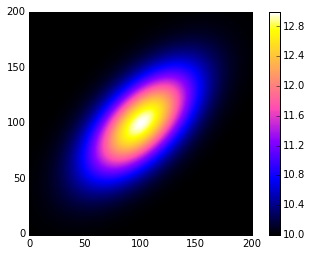

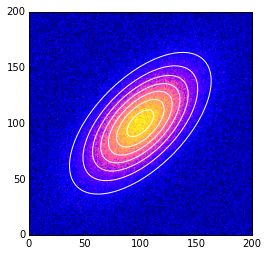

In [6]:
#define model function and pass independant variables x and y as a list
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, pi/4, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201),origin='bottom')
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

popt, pcov = curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

#And plot the results:

data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
data_noisy.shape = (201, 201)
ax.imshow(data_noisy.reshape(201, 201), origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')

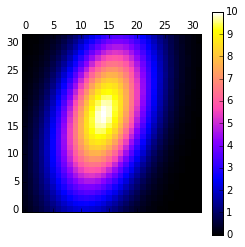

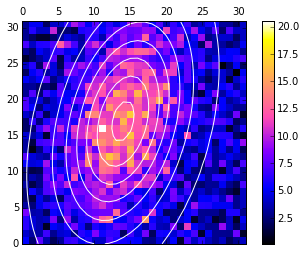

In [7]:
# Create x and y indices
x = arange(32)
y = arange(32)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 10, 14, 17, 5, 10, pi/12, 0)

# plot twoD_Gaussian data generated above
plt.figure()
plt.matshow(data.reshape(32, 32),origin='bottom')
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,16,16,5,5,0,10)

data_noisy = data + np.random.poisson(4, size=data.shape)

popt, pcov = curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

#And plot the results:

data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
data_noisy.shape = (32, 32)
data.shape = (32, 32)
img = ax.matshow(data_noisy.reshape(32, 32), origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(32, 32), 8, colors='w')
colorbar(img)

In [8]:
def _general_function_mle(params, xdata, ydata, function):
    # calculate the function
    f = function(xdata, *params)
    # calculate the MLE version of chi2
    chi2 = 2*(f - ydata - ydata * np.log(f/ydata))
    # return the sqrt because the np.leastsq will square and sum the result
    if chi2.min() < 0:
        return nan_to_num(inf)*ones_like(chi2)
    else:
        return np.sqrt(chi2)

    
def _weighted_general_function_mle(params, xdata, ydata, function, weights):
    return weights * (_general_function_mle(params, xdata, ydata, function))


def _general_function_ls(params, xdata, ydata, function):
    return function(xdata, *params) - ydata


def _weighted_general_function_ls(params, xdata, ydata, function, weights):
    return weights * _general_function_ls(params, xdata, ydata, function)

[  9.59574172  14.08161948  16.93461961   5.23862105   9.40713411
   4.08501096]
[  9.66514812  14.17445881  17.03352482   5.12652155   9.29181709
   4.14315514]


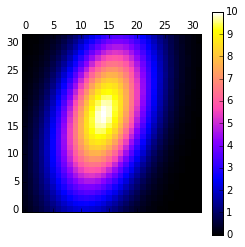

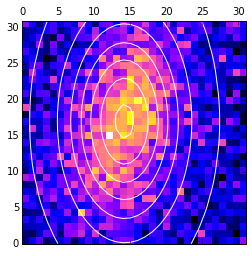

In [14]:
##Here's my modifcation to the above code

#define model function and pass independant variables x and y as a list
def gaussian2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple
    g = offset + amp*exp( -((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2)))                                   
    return g

#create a wrapper function
def gaussian2D_fit(*args):
    return gaussian2D(*args).ravel()

def gaussian2D_sym(xdata_tuple, amp, x0, y0, sigma_x, offset):
    (x, y) = xdata_tuple
    g = offset + amp*exp( -((x-x0)**2+(y-y0)**2)/(2*sigma_x**2))
    return g

#create a wrapper function
def gaussian2D_sym_fit(*args):
    return gaussian2D_sym(*args).ravel()

# # Create x and y indices
# x = arange(32)
# y = arange(32)
# x, y = np.meshgrid(x, y)

# #create data
# real_params = array([10, 14, 17, 2, 4, 0])
# data = gaussian2D((x, y), *real_params)

# plot twoD_Gaussian data generated above
plt.figure()
plt.matshow(data,origin='bottom')
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (10,12,15,5,7,8)

data_noisy = data + random.poisson(4, data.shape)

mp._general_function = _general_function_mle
mp._weighted_general_function = _weighted_general_function_mle
popt_mle, pcov_mle = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess)

mp._general_function = _general_function_ls
mp._weighted_general_function = _weighted_general_function_ls
popt, pcov = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess)

#And plot the results:

data_fitted = gaussian2D((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(data_noisy, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted, 8, colors='w')
print(popt_mle)
print(popt)
#[  2.97066005  31.99547047  31.96779469   4.97361061   9.97955038  1.20776079]

With my method of using a wrapper function to prepare the data for fitting I avoid the need to reshape the data for plotting and later analysis, but it means I need to `ravel` the y-data.

In [10]:
# define jacobians for timing experiments.
def myDfun( params, xdata, ydata, f):
    x = xdata[0].ravel()
    y = xdata[1].ravel()
    amp, x0, y0, sigma_x, sigma_y, offset = params
    value = f(xdata, *params)-offset
    dydamp = value/amp
    dydx0 = value*(x-x0)/sigma_x**2
    dydsigmax = value*(x-x0)**2/sigma_x**3
    dydy0 = value*(y-y0)/sigma_y**2
    dydsigmay = value*(y-y0)**2/sigma_y**3
    return vstack((dydamp, dydx0, dydy0, dydsigmax, dydsigmay, ones_like(value)))

def myDfun_sym( params, xdata, ydata, f):
    x = xdata[0].ravel()
    y = xdata[1].ravel()
    amp, x0, y0, sigma_x, offset = params
    value = f(xdata, *params)-offset
    dydamp = value/amp
    dydx0 = value*(x-x0)/sigma_x**2
    dydsigmax = value*(x-x0)**2/sigma_x**3
    dydy0 = value*(y-y0)/sigma_x**2
    return vstack((dydamp, dydx0, dydy0, dydsigmax, ones_like(value)))

In [11]:
myDfun(popt, (x, y), data_noisy.ravel(), gaussian2D_fit)[0].shape

(1024,)

## Testing timing
Comparing using a Jacobian vs not using one

In [12]:
# With MLE fitting
mp._general_function = _general_function_mle
mp._weighted_general_function = _weighted_general_function_mle
%timeit popt, pcov = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess, Dfun=myDfun, col_deriv=1)
%timeit popt, pcov = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess)

100 loops, best of 3: 5.21 ms per loop
100 loops, best of 3: 8.41 ms per loop


In [15]:
# With least squares fitting for a non-symmetric model function
mp._general_function = _general_function_ls
mp._weighted_general_function = _weighted_general_function_ls
%timeit popt, pcov = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess, Dfun=myDfun, col_deriv=1)
%timeit popt, pcov = mp.curve_fit(gaussian2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess)

# With least squares for a symmetric model function
mp._general_function = _general_function_ls
mp._weighted_general_function = _weighted_general_function_ls
initial_guess2 = (10,12,15,5,8)
%timeit popt, pcov = mp.curve_fit(gaussian2D_sym_fit, (x, y), data_noisy.ravel(), p0=initial_guess2, Dfun=myDfun_sym, col_deriv=1)
%timeit popt, pcov = mp.curve_fit(gaussian2D_sym_fit, (x, y), data_noisy.ravel(), p0=initial_guess2)

100 loops, best of 3: 3.42 ms per loop
100 loops, best of 3: 5.09 ms per loop
100 loops, best of 3: 7.84 ms per loop
100 loops, best of 3: 5.02 ms per loop


100 loops, best of 3: 15 ms per loop
100 loops, best of 3: 4.37 ms per loop
100 loops, best of 3: 4.63 ms per loop


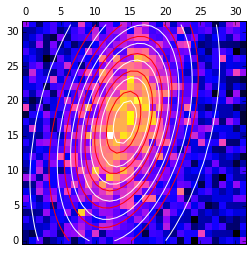

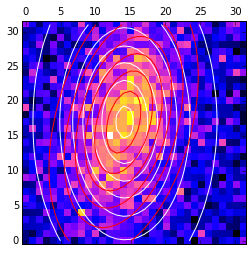

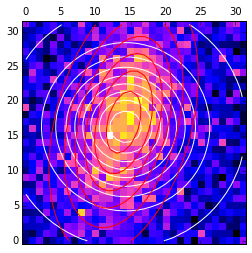

In [16]:
# Testing my class, notice its slower, but there's a lot more
junk_g = Gauss2D(data_noisy)


junk_g.optimize_params(modeltype='full')
%timeit junk_g.optimize_params(junk_g.guess_params)
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(junk_g.data, origin='bottom')
(y, x) = indices(junk_g.data.shape)
ax.contour(x, y, junk_g.fit_model, 8, colors='w')
ax.contour(x, y, data, 8, colors='r')

junk_g.optimize_params(modeltype='norot')
%timeit junk_g.optimize_params(junk_g.guess_params)
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(junk_g.data, origin='bottom')
(y, x) = indices(junk_g.data.shape)
ax.contour(x, y, junk_g.fit_model, 8, colors='w')
ax.contour(x, y, data, 8, colors='r')

junk_g.optimize_params(modeltype='sym')
%timeit junk_g.optimize_params(junk_g.guess_params)
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(junk_g.data, origin='bottom')
(y, x) = indices(junk_g.data.shape)
ax.contour(x, y, junk_g.fit_model, 8, colors='w')
ax.contour(x, y, data, 8, colors='r')

# Lorentzians

In [ ]:
##Here's my modifcation to the above code

#define model function and pass independant variables x and y as a list
def lor2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple
    g = offset + amp/(1+((x-x0)/(sigma_x/2))**2)/(1+((y-y0)/(sigma_y/2))**2)
    return g

#create a wrapper function
def lor2D_fit(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset):
    return gaussian2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset).ravel()

# Create x and y indices
x = arange(64)
y = arange(64)
x, y = np.meshgrid(x, y)

#create data
data = lor2D((x, y), 3, 32, 32, 5, 10, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.matshow(data,origin='bottom')
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (4,0,30,25,35,8)

data_noisy = data + 0.2*randn(*data.shape)

popt, pcov = curve_fit(lor2D_fit, (x, y), data_noisy.ravel(), p0=initial_guess)

#And plot the results:

data_fitted = lor2D((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.matshow(data_noisy, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted, 8, colors='w')